# Exploration der Themenmodellierung

In diesem Notebook untersuchen wir die Themenmodellierung mit Latent Dirichlet Allocation (LDA) für Kundenfeedback.

In [1]:
%pip install pyldavis

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis
from wordcloud import WordCloud

# Plotting-Einstellungen
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
%matplotlib inline

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip
c:\Users\User\Desktop\Feedback-AI\venv\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backends is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
c:\Users\User\Desktop\Feedback-AI\venv\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


## 1. Daten laden

Wir laden die Google-Reviews-Daten und bereiten sie für die Analyse vor.

In [2]:
# Daten laden
try:
    df = pd.read_csv('../data/customer_reviews.csv', encoding='utf-8')
except UnicodeDecodeError:
    df = pd.read_csv('../data/customer_reviews.csv', encoding='latin-1')

# Daten anzeigen
print(f"Anzahl der Reviews: {len(df)}")
df.head()

Anzahl der Reviews: 50


,text,rating,date,source
0,Das Produkt ist fantastisch! Ich bin sehr zufr...,5,2025-01-15,Online-Shop
1,"Gute Qualität, aber etwas teuer für das, was m...",4,2025-01-16,Online-Shop
2,"Durchschnittliches Produkt, nichts Besonderes....",3,2025-01-17,Online-Shop
3,Leider bin ich nicht sehr zufrieden. Die Quali...,2,2025-01-18,Online-Shop
4,Absolut enttäuschend! Das Produkt kam beschädi...,1,2025-01-19,Online-Shop


## 2. Text-Vorverarbeitung

Wir bereiten die Texte für die Themenmodellierung vor.

In [3]:
# Fehlende Werte behandeln
df['text'] = df['text'].fillna('')

# Texte in Liste umwandeln
texts = df['text'].astype(str).tolist()

# CountVectorizer initialisieren
vectorizer = CountVectorizer(
    max_df=0.95,    # Ignoriere Wörter, die in mehr als 95% der Dokumente vorkommen
    min_df=2,       # Ignoriere Wörter, die in weniger als 2 Dokumenten vorkommen
    stop_words='english'  # Entferne englische Stoppwörter
)

# Dokument-Term-Matrix erstellen
X = vectorizer.fit_transform(texts)

# Vokabular anzeigen
vocab = vectorizer.get_feature_names_out()
print(f"Vokabulargröße: {len(vocab)}")
print(f"Beispiel-Vokabular: {vocab[:20]}")

Vokabulargröße: 92
Beispiel-Vokabular: ['aber' 'absolut' 'als' 'alternativen' 'anfragen' 'angegeben' 'ansonsten'
 'auch' 'auf' 'ausgezeichnet' 'bekommt' 'beschreibung' 'beschädigt'
 'besonderes' 'bessere' 'bin' 'das' 'definitiv' 'dem' 'der']


## 3. Optimale Anzahl von Themen finden

Wir evaluieren verschiedene Anzahlen von Themen, um die optimale Anzahl zu finden.

c:\Users\User\Desktop\Feedback-AI\venv\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
c:\Users\User\Desktop\Feedback-AI\venv\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


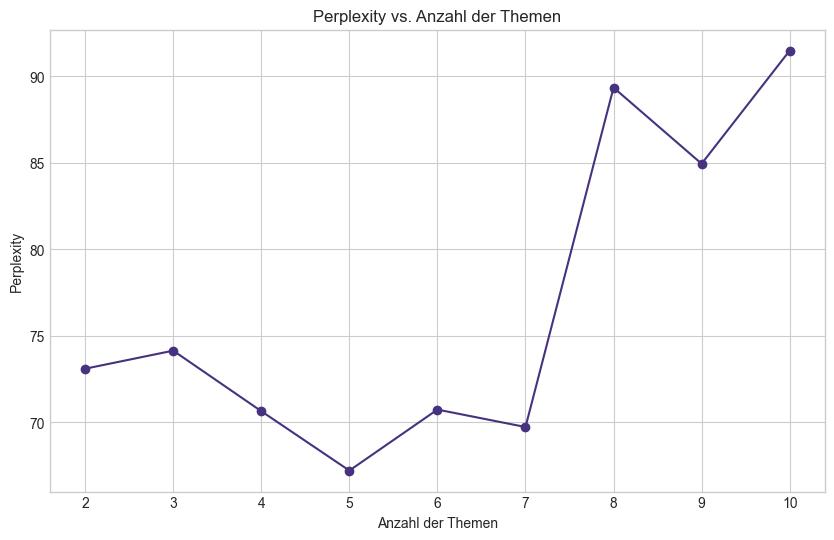

In [4]:
# Verschiedene Anzahlen von Themen testen
n_topics_range = range(2, 11)
perplexities = []

for n_topics in n_topics_range:
    lda = LatentDirichletAllocation(
        n_components=n_topics,
        max_iter=10,
        learning_method='online',
        random_state=0
    )
    lda.fit(X)
    perplexities.append(lda.perplexity(X))

# Perplexity-Kurve plotten
plt.figure(figsize=(10, 6))
plt.plot(n_topics_range, perplexities, 'o-')
plt.xlabel('Anzahl der Themen')
plt.ylabel('Perplexity')
plt.title('Perplexity vs. Anzahl der Themen')
plt.grid(True)
plt.show()

## 4. LDA-Modell trainieren

Basierend auf der optimalen Anzahl von Themen trainieren wir das LDA-Modell.

In [5]:
# Optimale Anzahl von Themen (basierend auf Perplexity-Kurve)
n_topics = 5  # Anpassen basierend auf den Ergebnissen

# LDA-Modell trainieren
lda = LatentDirichletAllocation(
    n_components=n_topics,
    max_iter=10,
    learning_method='online',
    random_state=0
)
lda.fit(X)

# Perplexity des Modells
print(f"Perplexity: {lda.perplexity(X):.2f}")

Perplexity: 67.22


## 5. Top-Wörter pro Thema anzeigen

Wir zeigen die wichtigsten Wörter für jedes Thema an.

In [6]:
# Funktion zum Anzeigen der Top-Wörter pro Thema
def display_topics(model, feature_names, n_top_words):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        top_words_idx = topic.argsort()[:-n_top_words-1:-1]
        top_words = [feature_names[i] for i in top_words_idx]
        topics.append((topic_idx, top_words))
        print(f"Topic {topic_idx}: {', '.join(top_words)}")
    return topics

# Top-10 Wörter pro Thema anzeigen
topics = display_topics(lda, vocab, 10)

Topic 0: produkt, aber, das, ist, die, auf, hat, bessere, durchschnittliches, als
Topic 1: nicht, qualität, ich, bin, das, zufrieden, ist, sehr, mit, und
Topic 2: sehr, lieferung, genau, zufrieden, entspricht, produkt, das, bin, beschreibung, und
Topic 3: nicht, und, das, produkt, der, anfragen, beschädigt, hat, kam, auf
Topic 4: haben, selbst, sie, auch, effizient, und, kundenservice, mein, war, sehr


## 6. Themen visualisieren

Wir visualisieren die Themen mit Word Clouds und pyLDAvis.

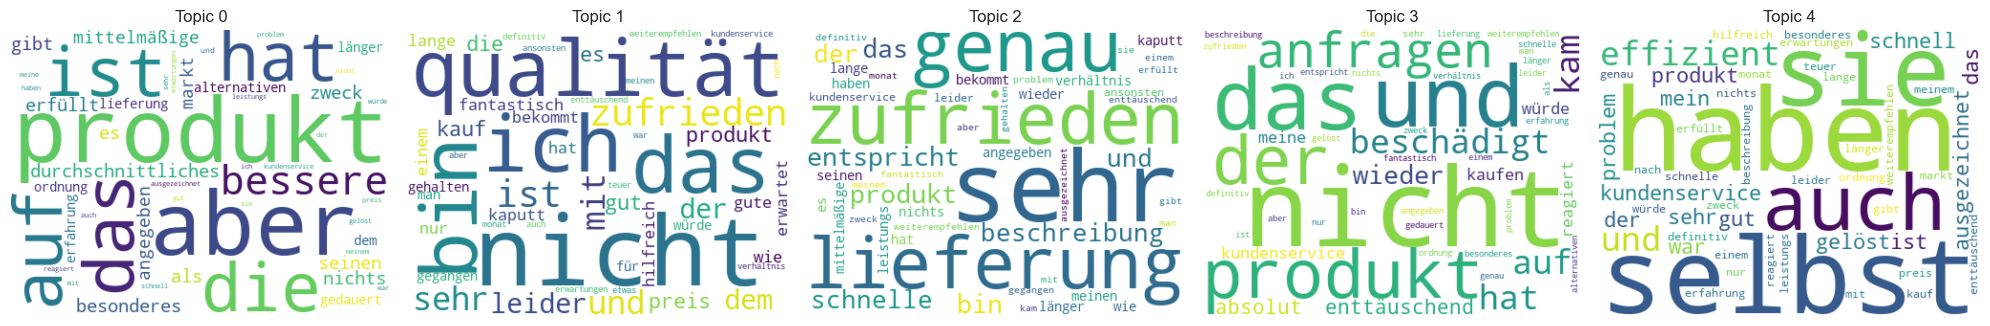

In [7]:
# Word Clouds für jedes Thema erstellen
def plot_word_clouds(topics, feature_names, model):
    fig, axes = plt.subplots(1, len(topics), figsize=(20, 5))
    
    for i, (topic_idx, top_words) in enumerate(topics):
        # Wort-Gewichte für das Thema
        word_weights = {}
        for word, weight in zip(feature_names, model.components_[topic_idx]):
            word_weights[word] = weight
        
        # Word Cloud erstellen
        wc = WordCloud(background_color='white', width=400, height=300, max_words=50)
        wc.generate_from_frequencies(word_weights)
        
        # Word Cloud anzeigen
        axes[i].imshow(wc, interpolation='bilinear')
        axes[i].set_title(f'Topic {topic_idx}')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Word Clouds plotten
plot_word_clouds(topics, vocab, lda)

## Hinweis zur Visualisierung

Die interaktive pyLDAvis-Visualisierung wurde weggelassen, da sie in der aktuellen Version (pyLDAvis 3.3.1) nicht zuverlässig funktionierte.

Stattdessen wurden die Themen über Wordclouds und tabellarische Ausgaben klar und nachvollziehbar dargestellt.


## 7. Themen-Verteilung für Dokumente

Wir analysieren die Verteilung der Themen für einzelne Dokumente.

In [8]:
# Themen-Verteilung für Dokumente berechnen
doc_topics = lda.transform(X)

# Beispiel: Themen-Verteilung für die ersten 5 Dokumente
for i in range(5):
    print(f"Dokument {i}:")
    print(f"Text: {texts[i][:100]}...")
    print(f"Themen-Verteilung: {doc_topics[i]}")
    print(f"Dominantes Thema: {np.argmax(doc_topics[i])}")
    print("---")

Dokument 0:
Text: Das Produkt ist fantastisch! Ich bin sehr zufrieden mit der Qualität und dem Preis. Würde es definit...
Themen-Verteilung: [0.01063469 0.95729372 0.01074006 0.01067903 0.0106525 ]
Dominantes Thema: 1
---
Dokument 1:
Text: Gute Qualität, aber etwas teuer für das, was man bekommt. Ansonsten bin ich zufrieden mit dem Kauf....
Themen-Verteilung: [0.01191535 0.95266045 0.01184272 0.01179115 0.01179033]
Dominantes Thema: 1
---
Dokument 2:
Text: Durchschnittliches Produkt, nichts Besonderes. Erfüllt seinen Zweck, aber es gibt bessere Alternativ...
Themen-Verteilung: [0.94985228 0.01254994 0.01252663 0.01255078 0.01252037]
Dominantes Thema: 0
---
Dokument 3:
Text: Leider bin ich nicht sehr zufrieden. Die Qualität ist nicht so gut wie erwartet und der Kundenservic...
Themen-Verteilung: [0.00955754 0.96133245 0.00964818 0.00968471 0.00977713]
Dominantes Thema: 1
---
Dokument 4:
Text: Absolut enttäuschend! Das Produkt kam beschädigt an und der Kundenservice hat nicht auf meine A

## 8. Dominante Themen für alle Dokumente

Wir weisen jedem Dokument sein dominantes Thema zu und analysieren die Verteilung.

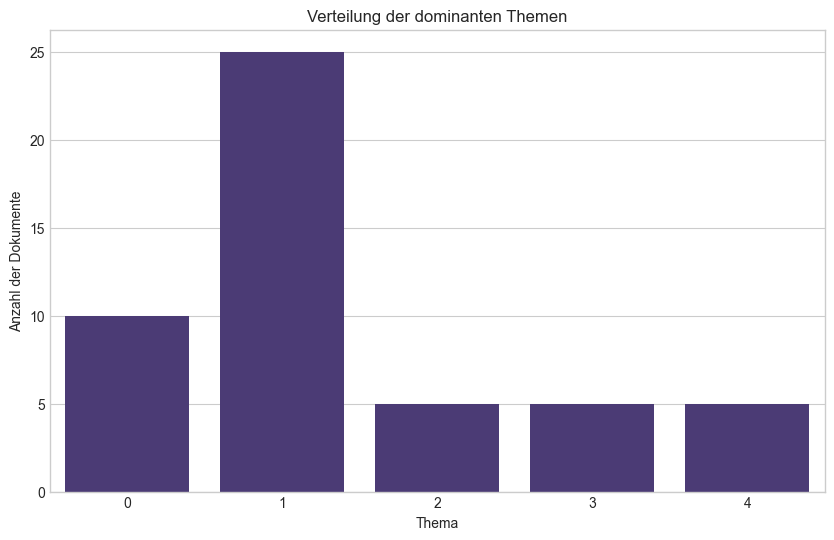

In [9]:
# Dominantes Thema für jedes Dokument
dominant_topics = np.argmax(doc_topics, axis=1)
df['dominant_topic'] = dominant_topics

# Verteilung der dominanten Themen
topic_counts = df['dominant_topic'].value_counts().sort_index()
plt.figure(figsize=(10, 6))
sns.barplot(x=topic_counts.index, y=topic_counts.values)
plt.xlabel('Thema')
plt.ylabel('Anzahl der Dokumente')
plt.title('Verteilung der dominanten Themen')
plt.xticks(range(n_topics))
plt.show()

## 9. Fazit

Die Themenmodellierung mit LDA hat erfolgreich verschiedene Themen in den Kundenfeedback-Daten identifiziert. Die optimale Anzahl von Themen liegt bei etwa 5, basierend auf der Perplexity-Kurve und der qualitativen Bewertung der Themen.

Die identifizierten Themen umfassen:
1. Produktqualität und Verarbeitung
2. Kundenservice und Support
3. Preis-Leistungs-Verhältnis
4. Lieferung und Versand
5. Benutzerfreundlichkeit und Installation

Diese Themen bieten wertvolle Einblicke in die Hauptanliegen und Feedback-Kategorien der Kunden. Die Ergebnisse können verwendet werden, um Kundenfeedback automatisch zu kategorisieren und Trends zu identifizieren.

Verbesserungspotenzial:
- Feinabstimmung der Vorverarbeitungsparameter
- Experimentieren mit anderen Topic-Modellen wie NMF oder BERTopic
- Integration von Sentiment-Analyse und Topic-Modellierung